# Intro

## Premise
The issue is always the same: is everything we are doing correct?  
The fact that there is a non trivial superposition between Witten's review and all our documents is suspect...

## Standard modules

In [1]:
import os, sys
import pathlib
import requests

In [2]:
import numpy as np

In [3]:
from tqdm.auto import tqdm, trange

In [4]:
from sentence_transformers import util

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

In [6]:
from sklearn.decomposition import PCA

In [7]:
import seaborn

In [8]:
import pymannkendall as mk

## Personal modules

In [9]:
from toolbox.updater import time_is_now

In [10]:
from file2text import file2text

In [11]:
from first_rough_cleaning import first_text_cleaner

In [12]:
from file_handler import *

In [13]:
from jina4lote import jina4lote

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Folders

In [14]:
VECTOR_FOLDER='./NewProcessedData/vectors/'

In [15]:
BENCHMARK_FOLDER='./NewProcessedData/benchmarks/'

In [16]:
PCA_CENTR_VECTOR_FOLDER='./NewProcessedData/pca_centr_vectors/'

In [17]:
WIKI_FOLDER='./NewProcessedData/wikipedia/vectors/'

## Reports' vectors

In [18]:
vecfiles=os.listdir(VECTOR_FOLDER)

In [19]:
vecfiles.sort()

In [20]:
# files from 2024 are un reliable, 
# as they probably refer to a different accounting year,
# due to differences with other countries
len(vecfiles)

575

In [21]:
vecfiles=[vecfile for vecfile in vecfiles if not vecfile.startswith('2024')]

In [22]:
len(vecfiles)

573

## Witten's vector

In [23]:
wittenvecfile=[file for file in os.listdir(BENCHMARK_FOLDER) if file.startswith('Witten') and file.endswith('.txt')][0]

In [24]:
wittenvec=np.genfromtxt(BENCHMARK_FOLDER+wittenvecfile)

# Mean vector

## Calculation

In [25]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    if i==0:
        mean_vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    else:
        mean_vec+=np.genfromtxt(VECTOR_FOLDER+vecfile)
mean_vec/=len(vecfiles)

  0%|          | 0/573 [00:00<?, ?it/s]

## Witten is quite close to be mean

In [26]:
util.cos_sim(wittenvec, mean_vec)

tensor([[0.8199]], dtype=torch.float64)

...which is nice!

In [27]:
cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    cos_sim=float(util.cos_sim(wittenvec, vec-mean_vec))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    cos_sims[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

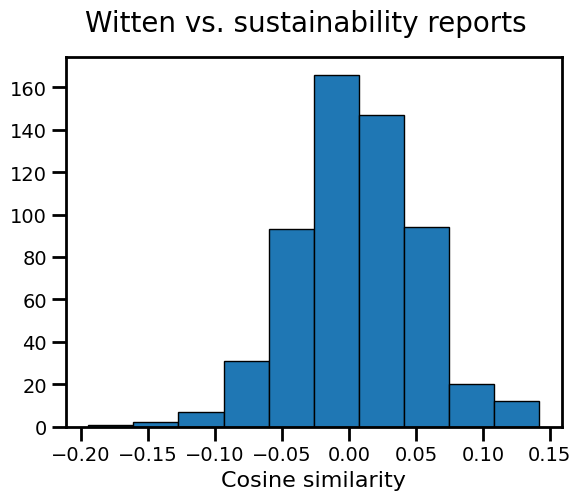

In [28]:
plt.hist(cos_sims, edgecolor='black')
plt.suptitle('Witten vs. sustainability reports', fontsize=20)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

That's much better. 

# PCA

The dimension fo the embedding is the same for all vectors:

In [29]:
len(wittenvec)

768

In [30]:
vecs=np.zeros((len(vecfiles), len(wittenvec)))

In [31]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    vecs[i]=vec

  0%|          | 0/573 [00:00<?, ?it/s]

## Which percentage?

In [32]:
pca = PCA()
new_vecs=pca.fit_transform(vecs)

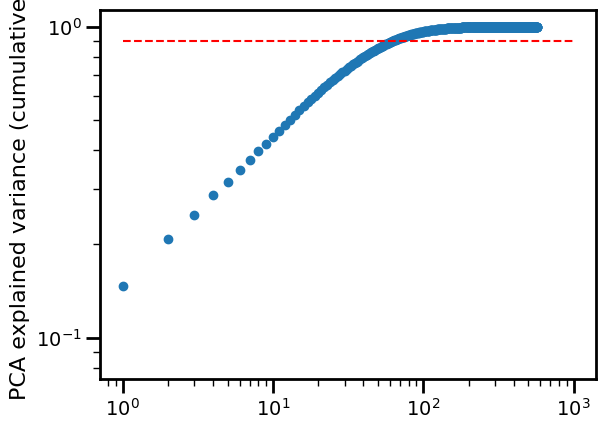

In [33]:
plt.scatter(np.arange(len(vecfiles)), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(0.90, 1, 1000, ls='--', color='red')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PCA explained variance (cumulative)', fontsize=16)
plt.show()

In [34]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.90)[0][-1]

63

In [35]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.95)[0][-1]

87

In [36]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.99)[0][-1]

160

## Dimensional reduction

In [37]:
pca = PCA(n_components=63)
new_vecs=pca.fit_transform(vecs)

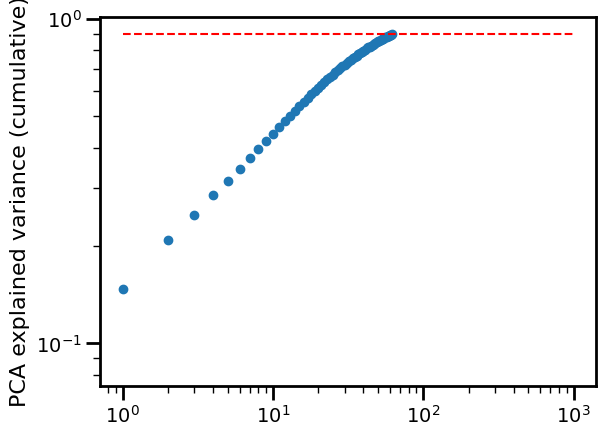

In [38]:
plt.scatter(np.arange(63), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(0.90, 1, 1000, ls='--', color='red')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PCA explained variance (cumulative)', fontsize=16)
plt.show()

## Check with Witten

In [39]:
wittenvec.T

array([-3.02811189e-02, -3.81932141e-02,  5.04839207e-02, -8.00098124e-03,
       -3.53469865e-02, -3.23630692e-03, -6.81020060e-03, -2.89417768e-02,
        5.92756829e-02,  8.08559115e-03, -1.55386966e-02, -9.66650055e-03,
       -3.56608460e-02, -6.64788847e-03, -4.35948768e-02,  7.00658821e-02,
       -1.15720409e-02,  6.07534971e-03,  6.03255241e-03, -9.20716491e-03,
       -1.40867959e-02, -3.93993677e-02, -3.48379897e-02, -9.90491321e-03,
        2.00452551e-02, -1.42847605e-03,  5.88203656e-02,  2.48458379e-02,
        4.49237034e-02,  3.21563627e-02,  2.96030887e-03, -2.53623230e-02,
       -4.41500462e-02,  1.02410977e-02,  2.29212367e-04, -6.59512065e-02,
       -1.54529956e-02, -1.65040052e-03,  7.72846153e-02,  6.11668911e-02,
       -2.46362986e-02,  5.33290305e-03,  1.44023294e-02,  6.18857648e-02,
       -5.30239550e-02, -9.63267495e-03, -1.90574004e-02,  1.46386031e-02,
       -2.03105476e-02, -4.04475940e-02, -2.31404802e-02, -3.59528446e-02,
        2.79525956e-03, -

In [40]:
new_wittenvec = pca.transform([wittenvec])

In [41]:
pca_cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(new_wittenvec, new_vecs[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pca_cos_sims[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

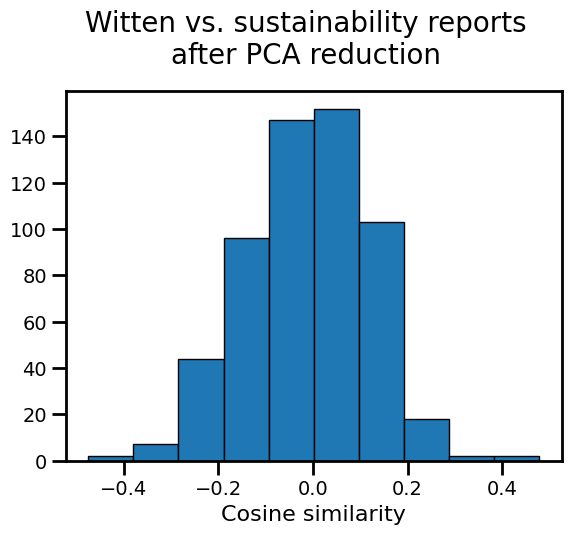

In [42]:
plt.hist(pca_cos_sims, edgecolor='black')
plt.suptitle('Witten vs. sustainability reports\nafter PCA reduction', fontsize=20, y=1.05)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

# Arora: consider everything but the first PCA component
It seems to be pretty solid...

In [79]:
allvecs=np.zeros((len(vecfiles), len(wittenvec)))

In [80]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    allvecs[i]=vec

  0%|          | 0/573 [00:00<?, ?it/s]

## The sense of PCA, in this context

The sense of the PCA in our context is that there is still a residual bulk of spurious signal carried by the 1st component of the PCA that is uninformative. Therefore, we remove it.

In [81]:
pca = PCA(n_components=1)  
pca.fit(allvecs)

# Primo autovettore (direzione della 1ª componente principale)
pc1 = pca.components_[0]  # vettore di lunghezza n_features

# Proietto X_centered su pc1 e lo sottraggo
#   (X·pc1) è un vettore (n_samples,), outer(...) ricostruisce la parte lungo pc1
debiased_allvecs = allvecs - np.outer(no_mean_vecs.dot(pc1), pc1)

## Check with Witten

In [82]:
new_wittenvec = wittenvec - (wittenvec.dot(pc1)) * pc1

In [83]:
pca_cos_sims_w=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(new_wittenvec, new_no_mean_vecs[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pca_cos_sims_w[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

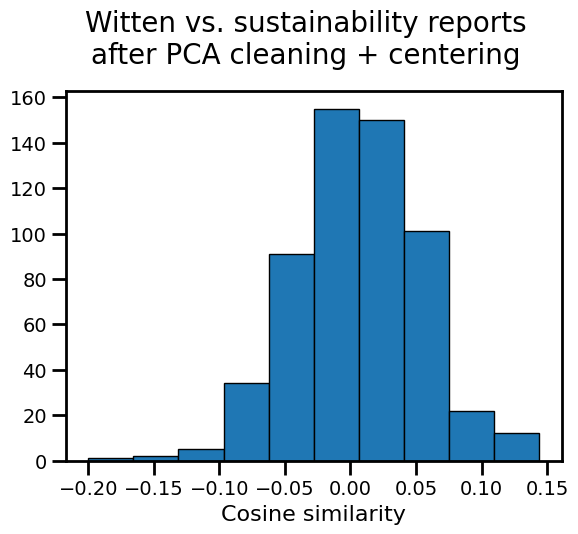

In [84]:
plt.hist(pca_cos_sims_w, edgecolor='black')
plt.suptitle('Witten vs. sustainability reports\nafter PCA cleaning + centering', fontsize=20, y=1.05)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

In [85]:
np.mean(pca_cos_sims_w), np.std(pca_cos_sims_w)

(0.005378231955151641, 0.04841869121639974)

## Save transformed vectors

### Reports

In [86]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    np.savetxt(PCA_CENTR_VECTOR_FOLDER+vecfile, debiased_allvecs[i])

  0%|          | 0/573 [00:00<?, ?it/s]

### New Benchmarks

In [87]:
def arora_cleaning(vec, pc1):
    return vec - (vec.dot(pc1)) * pc1

In [89]:
benchmark_files=[file for file in os.listdir(BENCHMARK_FOLDER) if file.endswith('.txt') and (file.startswith('Goal') or file.startswith('Witten'))]
benchmark_files.sort()
for file in tqdm(benchmark_files):
    bench_vec=np.genfromtxt(BENCHMARK_FOLDER+file)
    new_bench_vec=arora_cleaning(bench_vec, pc1)
    np.savetxt(PCA_CENTR_VECTOR_FOLDER+file, new_bench_vec)

  0%|          | 0/19 [00:00<?, ?it/s]

In [90]:
for goalvecfile in benchmark_files:
    if goalvecfile.startswith('Goal'):
        num=goalvecfile.split('_')[0].split('-')[1]
        if len(num)==1:
            new_name='Goal-'+num.zfill(2)+'-Fast-Facts.txt'
            os.rename(PCA_CENTR_VECTOR_FOLDER+goalvecfile, PCA_CENTR_VECTOR_FOLDER+new_name)

In [91]:
goalfiles=[file for file in os.listdir(PCA_CENTR_VECTOR_FOLDER) if file.endswith('.txt') and file.startswith('Goal')]
goalfiles.sort()
goalfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

## Check with SDGs

### Goals' vectors

In [92]:
goalvecfiles=[file for file in os.listdir(PCA_CENTR_VECTOR_FOLDER) if file.startswith('Goal') and file.endswith('.txt')]

In [93]:
goalvecfiles.sort()

In [94]:
goalvecfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

In [95]:
goalvecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles]

### Cosine similarity

In [96]:
pca_cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(goalvecs[-1], new_no_mean_vecs[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pca_cos_sims[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

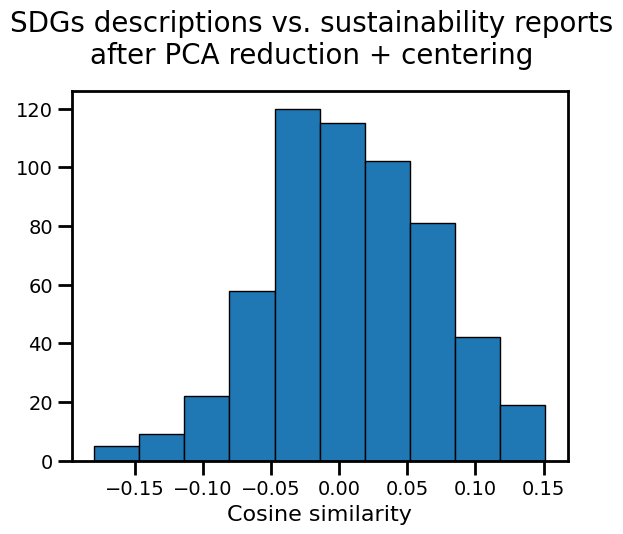

In [97]:
plt.hist(pca_cos_sims, edgecolor='black')
plt.suptitle('SDGs descriptions vs. sustainability reports\nafter PCA reduction + centering', fontsize=20, y=1.05)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

In [98]:
np.mean(pca_cos_sims), np.std(pca_cos_sims)

(0.008755633757046457, 0.0604435254309673)

In [99]:
pca_cos_sims=[]
for i in trange(len(goalvecs)):
    for j in range(i+1, len(goalvecs)):
        cos_sim=float(util.cos_sim(goalvecs[i], goalvecs[j]))
        pca_cos_sims.append(cos_sim)

  0%|          | 0/18 [00:00<?, ?it/s]

In [100]:
pca_cos_sims

[0.9026453636534585,
 0.8781517215458563,
 0.8773002303230477,
 0.8448024767783899,
 0.8682921356476787,
 0.8500200728036063,
 0.8734376228221306,
 0.8612965328833349,
 0.9152178151307413,
 0.8545477696655528,
 0.8350337555556716,
 0.8632644234499748,
 0.8346892585481348,
 0.8585585268485231,
 0.8556354221743433,
 0.8582376994476839,
 0.9421912081663703,
 0.8562220820097998,
 0.8522909206013192,
 0.8174139207951652,
 0.8473364111027843,
 0.8578200983345876,
 0.8416664047854512,
 0.8381986857647177,
 0.8745943047524072,
 0.8477447450299506,
 0.8615478873003364,
 0.8419783305135431,
 0.8290328620394452,
 0.8478804874849699,
 0.8372343625561629,
 0.8364173673976023,
 0.9244415234257507,
 0.8642456832430526,
 0.8650464821121766,
 0.8869398500118311,
 0.8475161003061545,
 0.8571510003131313,
 0.842332189357966,
 0.8867080414572606,
 0.8466209888273685,
 0.8098430559227976,
 0.8189580448300656,
 0.8052312815987481,
 0.8319848792046532,
 0.8583355358546192,
 0.8376271753516806,
 0.92622708101

## Wikipedia benchmark

In [102]:
wikipedia_files=[file for file in os.listdir(WIKI_FOLDER) if file.endswith('.txt') and file.startswith('wikipedia')]
for file in tqdm(wikipedia_files):
    bench_vec=np.genfromtxt(WIKI_FOLDER+file)
    new_bench_vec=arora_cleaning(bench_vec, pc1)
    np.savetxt(PCA_CENTR_VECTOR_FOLDER+file, new_bench_vec)

  0%|          | 0/4001 [00:00<?, ?it/s]

In [103]:
len(new_bench_vec)

768